In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
import random

import scipy.cluster.hierarchy as sch
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

from random import gauss
from datetime import datetime

In [2]:
INPUT = 'output/\CompleteWeeklyIndexes'
#INPUT = 'C:/\Projetos/\dissertacao_media/\dissertacao/\output/\CompleteWeeklyIndexes'

In [3]:
lower_bound = 1
upper_bound = 10
lower_bound2 = 100
upper_bound2 = 200
upper_bound_white_noise = 2
datelist = pd.date_range(datetime.today(), periods=1000).tolist()

def generate_white_noise(index):
    white_noise = [gauss(0.0, 1.0) for i in range(len(index))]
    white_noise = pd.DataFrame(white_noise, index=index)
    return white_noise.iloc[:,0]

def generate_seasonal(index):
    k_s = random.randint(lower_bound, upper_bound)
    k_w = random.randint(lower_bound, upper_bound_white_noise)
    p = random.randint(lower_bound, upper_bound)
    #print(k_s, k_w, p)

    white_noise = generate_white_noise(index)
    x = np.arange(0, len(index)/10, 0.1)
    y = np.sin(p*x)*k_s
    seasonal = y + white_noise*k_w
    return seasonal

def generate_trended(index):
    k_t = random.randint(lower_bound, upper_bound)
    k_w = random.randint(lower_bound, upper_bound_white_noise)
    #print(k_t, k_w)

    white_noise = generate_white_noise(index)
    x = np.arange(0, len(index)/10, 0.1)
    trend =k_t*x + k_w*white_noise
    return trend

def generate_trend_and_seasonal(index):
    k_s = random.randint(lower_bound2, upper_bound2)
    k_t = random.randint(lower_bound, upper_bound)
    k_w = random.randint(lower_bound, upper_bound_white_noise)
    p = random.randint(lower_bound, upper_bound)
    #print(k_s, k_t, k_w, p)

    white_noise = generate_white_noise(index)
    x = np.arange(0, len(index)/10, 0.1)
    y = np.sin(p*x)*k_s
    seasonal_and_trend = y + k_w*white_noise + x*k_t
    return seasonal_and_trend

In [4]:
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0)
df_test = df.loc['2015-01-02':] #Selecting test data
df_train = df.loc['2000-01-01':'2015-01-01'] #Selecting training data


In [5]:
trend_seasonal= generate_trend_and_seasonal(df_train.index).rename("trend_seasonal_0")
trend = generate_trended(df_train.index).rename("trend_0")
seasonal = generate_seasonal(df_train.index).rename("seasonal_0")
white_noise = generate_white_noise(df_train.index).rename("white_noise_0")

for i in range(1,5):
    trend_seasonal_train = generate_trend_and_seasonal(df_train.index).rename("trend_seasonal_"+str(i))
    trend_train = generate_trended(df_train.index).rename("trend_"+str(i))
    seasonal_train = generate_seasonal(df_train.index).rename("seasonal_"+str(i))
    white_noise_train = generate_white_noise(df_train.index).rename("white_noise_"+str(i))
    trend_seasonal = pd.concat([trend_seasonal, trend_seasonal_train], axis=1, join='outer')
    trend = pd.concat([trend, trend_train], axis=1, join='outer')
    seasonal = pd.concat([seasonal, seasonal_train], axis=1, join='outer')
    white_noise = pd.concat([white_noise, white_noise_train], axis=1, join='outer')

trend_seasonal.to_csv(r'output\/trendAndSeasonal.csv', index = True, header=True)
trend.to_csv(r'output\/trend.csv', index = True, header=True)
seasonal.to_csv(r'output\/seasonal.csv', index = True, header=True)
white_noise.to_csv(r'output\/whiteNoise.csv', index = True, header=True)


trend_seasonal_train = pd.read_csv(r'output\/trendAndSeasonal.csv', parse_dates=True, index_col=0)
trend_train = pd.read_csv(r'output\/trend.csv', parse_dates=True, index_col=0)
seasonal_train = pd.read_csv(r'output\/seasonal.csv', parse_dates=True, index_col=0)
white_noise_train = pd.read_csv(r'output\/whiteNoise.csv', parse_dates=True, index_col=0)



In [6]:
def KScoeff(df):
    
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
            
    return ks_matrix

In [7]:
df_testing_method = pd.concat([trend_seasonal_train, trend_train, seasonal_train, white_noise_train], axis=1, join='outer')

In [8]:
df_train = pd.concat([df_train, trend_seasonal_train, trend_train, seasonal_train, white_noise_train], axis=1, join='outer')

In [9]:
### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###
data = np.asarray(df_train.T)
### STANDARDIZE DATA ###

for i,s in enumerate(data):
    data[i] = (data[i] - s.mean(axis=0)) / s.std(axis=0)
    
ks_matrix = KScoeff(data)



C:\Users\silva\Anaconda3\envs\mestrado\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


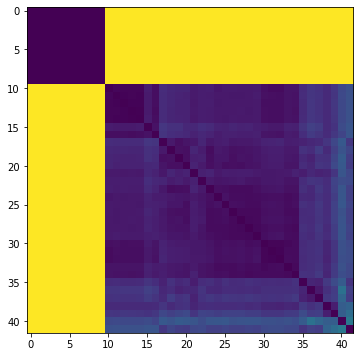

In [10]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [data[i] for i in dendrogram['leaves']]
labels = [df_train.columns[i] for i in dendrogram['leaves']]
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
np.set_printoptions(False)

6.141474859537459


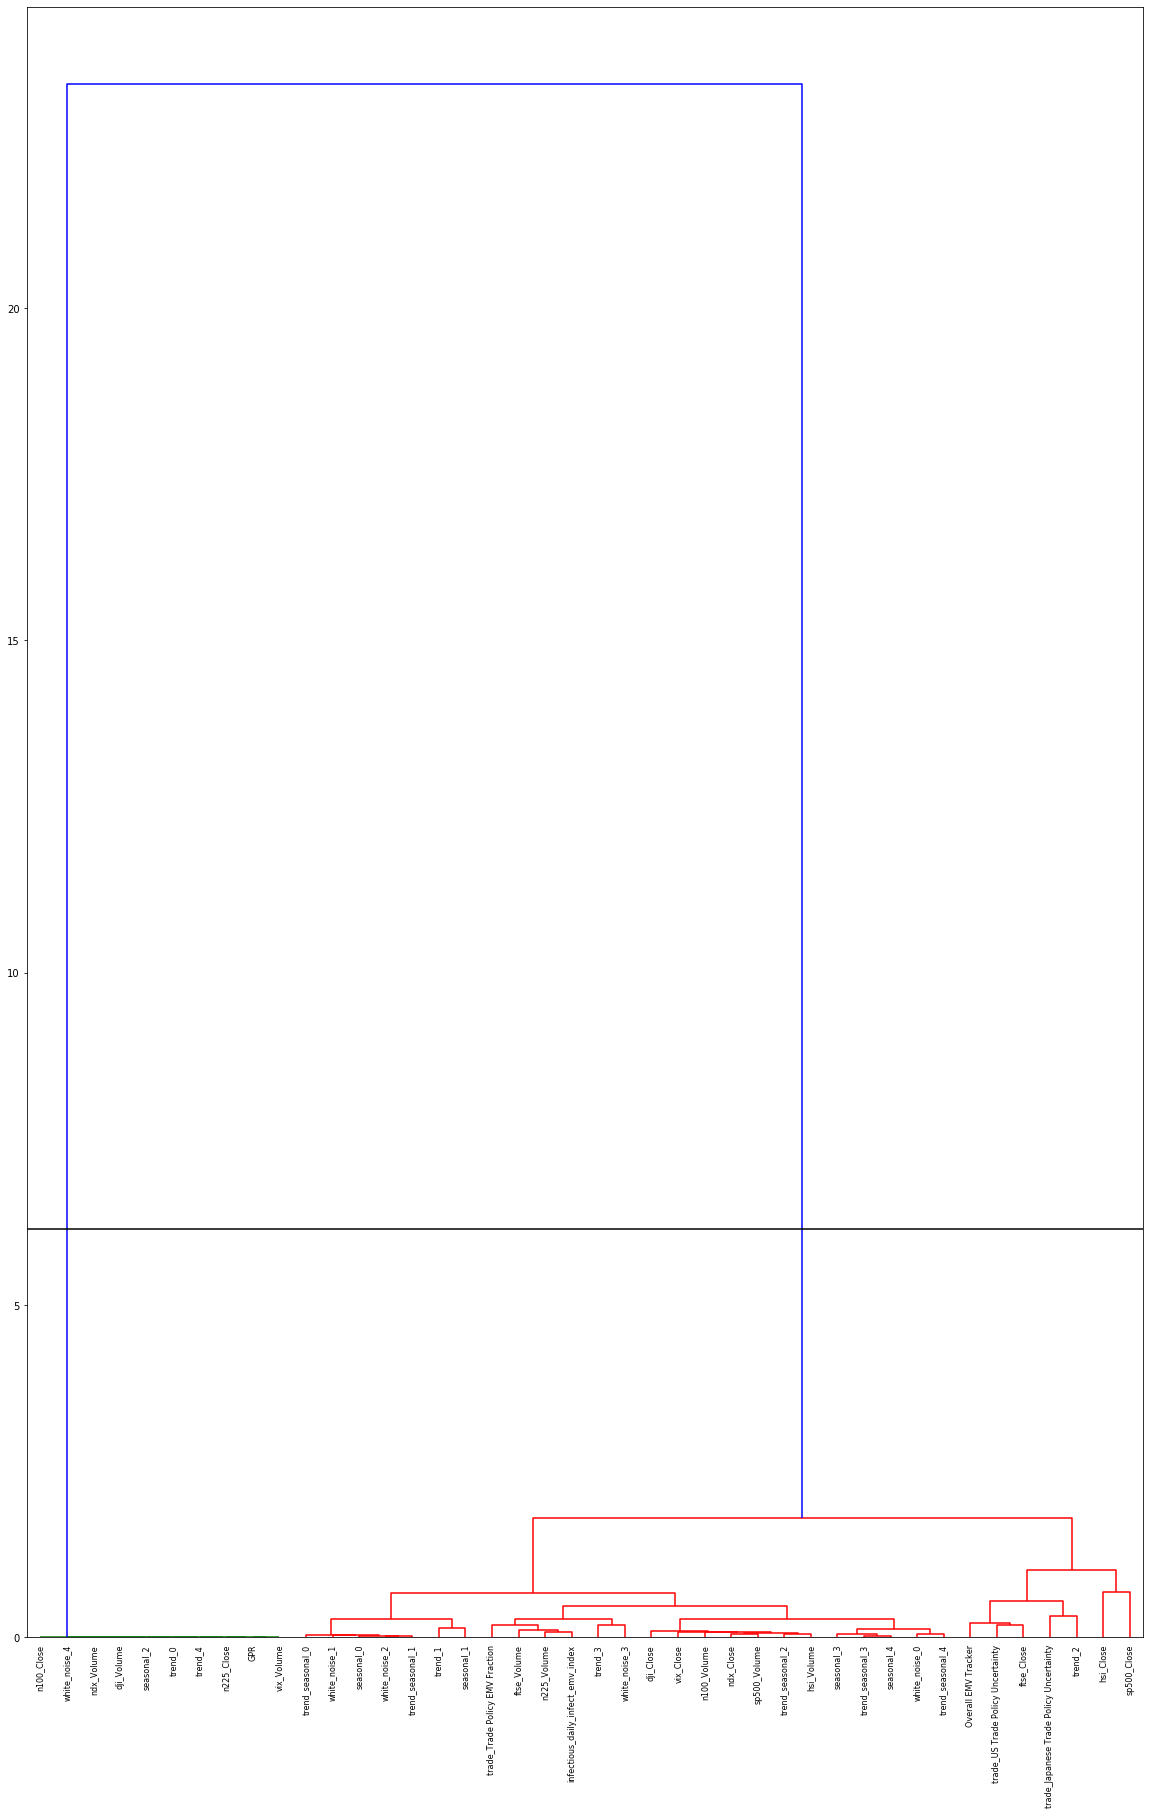

In [11]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(20,30))
dendrogram = sch.dendrogram(L, labels=labels)
plt.axhline(d.max(), c='black')
plt.xticks(rotation=90)
print(d.max())

In [12]:
print(d.max())

6.141474859537459


In [13]:
### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###
data = np.asarray(df_testing_method.T)
### STANDARDIZE DATA ###

for i,s in enumerate(data):
    data[i] = (data[i] - s.mean(axis=0)) / s.std(axis=0)
    
ks_matrix = KScoeff(data)



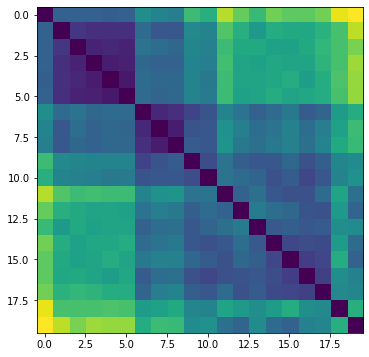

In [14]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [data[i] for i in dendrogram['leaves']]
labels = [df_testing_method.columns[i] for i in dendrogram['leaves']]
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
np.set_printoptions(False)

0.2514048283673199


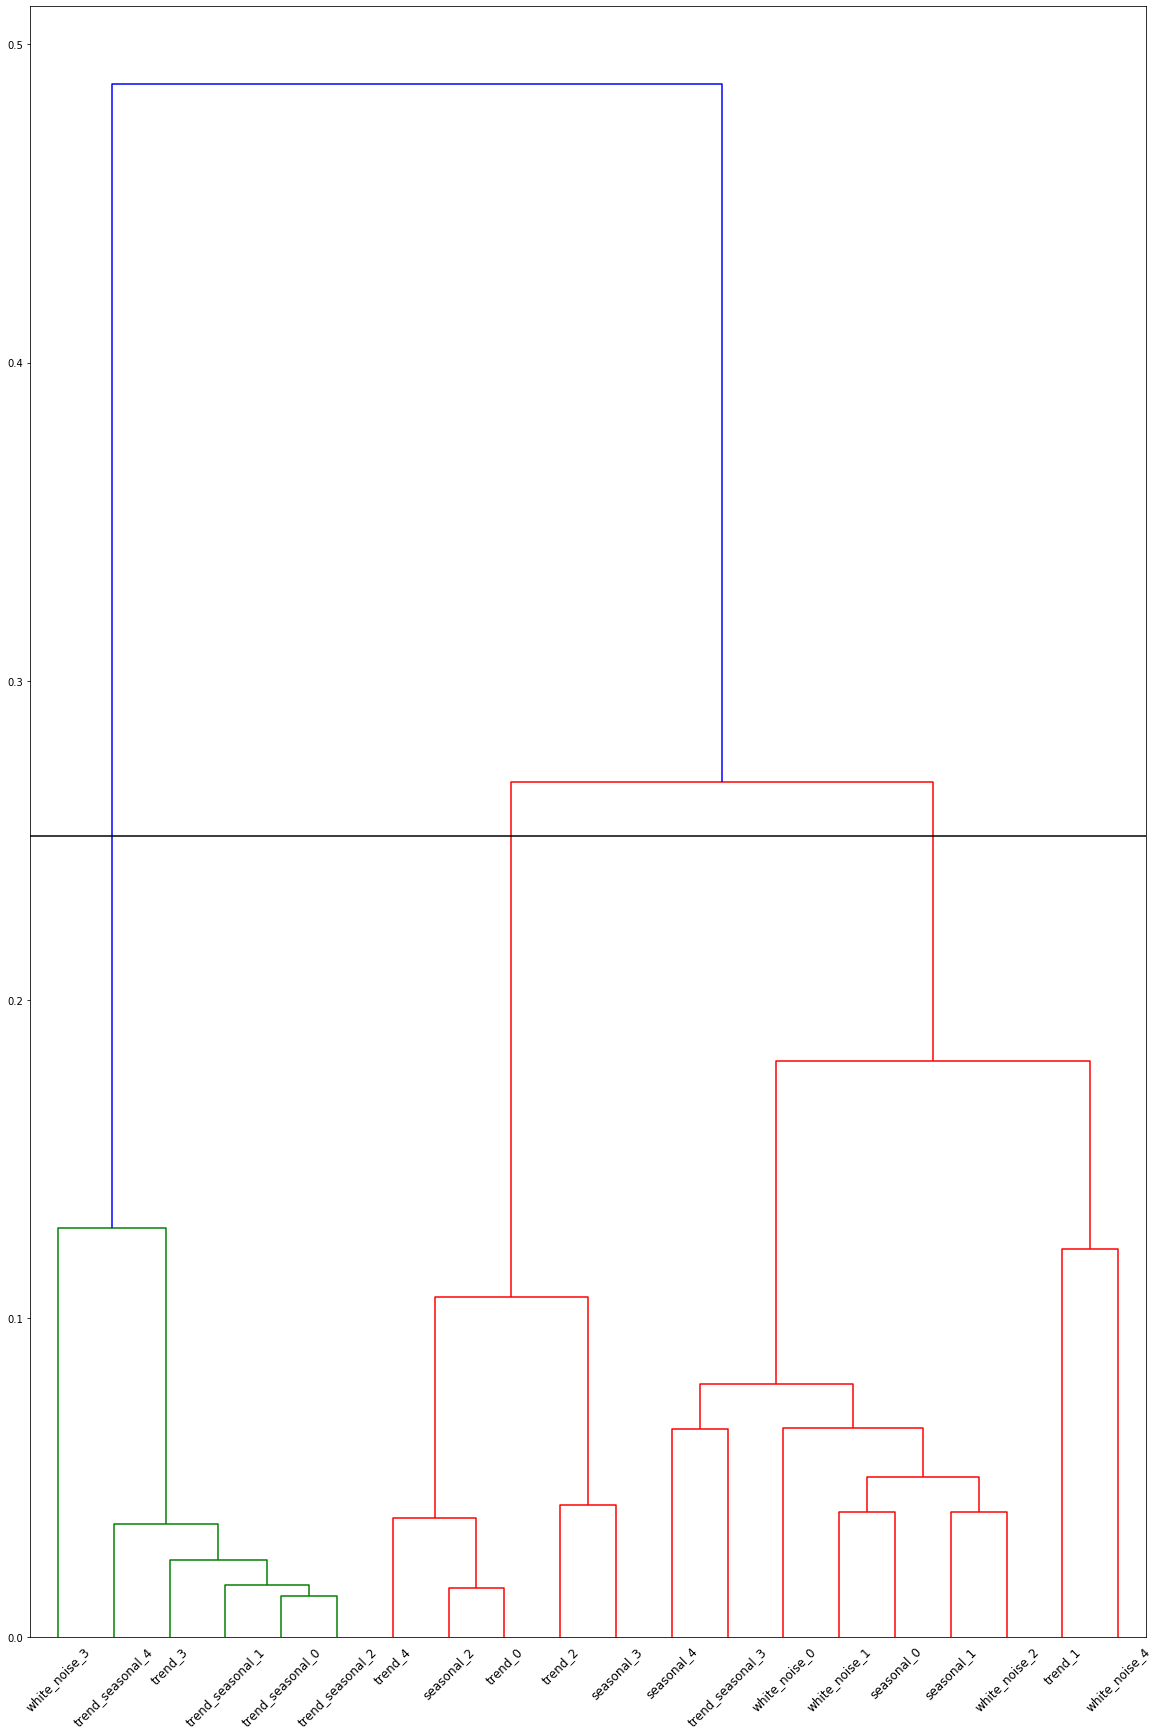

In [15]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(20,30))
dendrogram = sch.dendrogram(L, labels=labels)
plt.axhline(d.max(), c='black')
plt.xticks(rotation=45)
print(d.max())